# Problem Set 2

#### Done by **Fatykhoph Denis**, Skoltech, NLA, 2024

## Tensor Train (10 pts)

**Tensor** is a multidimensional array of shape $n_1 \times n_2 \times ... \times n_d$ where the number $d$ defines the dimensionality and every element can be get trough a multi-index $[i_1, i_2, \dots, i_d]$. If $d=1$ such tensor is simply a vector and if $d=2$ it is a $n_1 \times n_2$ matrix.

**Tensor Train** is a special tensor representation form that enables to efficently store high-dimensional tensors and perform mathematical operation with them. It was proposed in [link](https://www.researchgate.net/profile/Ivan-Oseledets/publication/220412263_Tensor-Train_Decomposition/links/5bbfb5c5299bf1004c5a56e3/Tensor-Train-Decomposition.pdf). Basically instead of storing all tensor entries $A[1_1, i_2, \dots, i_d]$ it was proposed to use a factorization trough specific 3D-tensors $G_i$ of shape $r_{i-1} \times n_i \times r_i$ that are called **cores**. Any entry $A[1_1, i_2, \dots, i_d]$ of tensor A can thus be computed as:

$$
A[i_1, i_2, \dots, i_d] =
\sum_{\alpha_0=1}^{r_0}
\sum_{\alpha_1=1}^{r_1}
\dots
\sum_{\alpha_d=1}^{r_d}
G_1[\alpha_0, i_1, \alpha_1] \; \cdot
G_2[\alpha_1, i_2, \alpha_2] \; \cdot
\dots \; \cdot
G_d[\alpha_{d-1}, i_d, \alpha_d],
$$

The numbers $r_i$ are are chosen during construction and called **ranks** of the representation:
1. boundary ranks $r_0 = r_N = 1$, ensuring the summation collapses to a scalar.
2. small ranks $r_i$ make the representation compact and memory efficient but increase the approximation error

TT decomposition is a generalization of matrix factorizations like SVD to higher dimensions, adapted for tensors.

### Tensor Train Construction

To construct the cores one needs to perform a TT-SVD algorithm: we start from $C_1 = A$ and then for every $k$ from 1 to $d$ we perform following steps untill we get all the cores:
1. Unfold matrix $C_k = C_k.reshape(r_{k-1} n_k, \prod_{i=k+1}^{d} n_i)$.
2. Perform a low-rank SVD for $C_k$ and get the matrices $U_k, \Sigma_k, V_k^*$ with rank $r_k <= \text{rank}(C_k)$.
3. Compute the core $G_k = U_k.reshape(r_{k-1}, n_k, r_k)$.
4. Update the matrix $C_{k+1} = \Sigma_k V_k^*$.

**Task (10 pts):** Realize TT-SVD for $d$-dimensional tensor and check it for a random tensor.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic

In [ ]:
ar = np.random.uniform(1, 15, (2, 3, 4))
len(ar.shape)

t = ar.shape
ic(t[1:])
np.prod(ar.shape[1:])

In [ ]:
def tt_svd(tensor:np.ndarray,
           max_rank:int = 10):
    """
    Convert a tensor into a tensor train.
    input : tensor - np.array of shape [n_1, n_2, ..., n_d]
            max_rank - maximal number that ranks r_0, ..., r_d can reach
    output: cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    """
    upper_bound = len(tensor.shape) - 1
    delta = ((max_rank/np.sqrt(upper_bound))
            * np.linalg.norm(tensor.flatten()))
    
    temp_tensor_C = tensor
    unfolding_rank = np.array([1,])
    cores = []
    for k in range(1, upper_bound):
        # temp_tensor_C = temp_tensor_C.reshape(unfolding_rank * temp_tensor_C.shape[k],
        #                                       np.prod(temp_tensor_C.shape[k:])) by formula

        temp_tensor_C = temp_tensor_C.reshape(unfolding_rank[k - 1] * tensor.shape[k], -1)
        u_k, sigma, v_k_T = np.linalg.svd(temp_tensor_C, full_matrices=False)
        unfolding_rank = np.append(unfolding_rank, len(sigma))
        core_k = u_k.reshape(unfolding_rank[k - 1], tensor.shape[k], -1)
        cores.append(core_k)
        temp_tensor_C = sigma @ v_k_T

    # cores.append(temp_tensor_C)
    cores.append(temp_tensor_C.reshape(unfolding_rank[-1], tensor.shape[-1], 1))

    return cores

d = 5
max_mode = 10
modes = np.random.randint(1, max_mode, size=(d))
A = np.random.randn(*modes)
tt_svd(A)


Based on original paper:

In [ ]:
def tt_svd(tensor: np.ndarray, epsilon: float = 1e-6):
    """
    Convert a tensor into a tensor train using TT-SVD.
    Input:
        tensor - Input tensor of shape [n_1, n_2, ..., n_d].
        epsilon: float - Desired accuracy for truncation.
    Output:
        cores: np.ndarray - List of TT-cores with shapes [r_i-1, n_i, r_i].
    """
    d = len(tensor.shape)
    delta = (epsilon / np.sqrt(d - 1)) * np.linalg.norm(tensor.flatten())
    
    temp_tensor_C = tensor
    unfolding_rank = [1]
    cores = []
    
    for k in range(d - 1):
        temp_tensor_C = temp_tensor_C.reshape(unfolding_rank[k] * tensor.shape[k], -1)
        u_k, sigma, v_k_T = np.linalg.svd(temp_tensor_C, full_matrices=False)
        
        truncation_indices = np.where(sigma > delta)[0]
        u_k = u_k[:, truncation_indices]
        sigma = sigma[truncation_indices]
        v_k_T = v_k_T[truncation_indices, :]
        
        unfolding_rank.append(len(sigma))
        core_k = u_k.reshape(unfolding_rank[k], tensor.shape[k], unfolding_rank[k + 1])
        cores.append(core_k)
        
        temp_tensor_C = np.diag(sigma) @ v_k_T
    
    cores.append(temp_tensor_C.reshape(unfolding_rank[-1], tensor.shape[-1], 1))
    
    return cores

# d = 5
# max_mode = 10
# modes = np.random.randint(1, max_mode, size=(d))
# A = np.random.randn(*modes)
# tt = tt_svd(A)

To check your algorithm you need to take a function `tt_to_tensor` that converts a tensor train back into a tensor, run it for a tensor train $\mathcal{A}$ that you would get from your original tensor $A$, and compare $A$ and $A'$ in terms of low-rank approximation error and memory.

In [ ]:
def tt_to_tensor(cores):
    """
    Convert a tensor train into a tensor.
    input : cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    output: tensor - np.array of shape [n_1, ..., n_d]
    """
    tensor = cores[0]
    for G in cores[1:]:
        tensor = np.tensordot(tensor, G, 1)
    return tensor[0, ..., 0]

In [ ]:
for core in tt:
    ic(core.shape)
a_rec = tt_to_tensor(tt)
ic(a_rec.shape)
ic(A.shape)

In [ ]:
d = 5
max_mode = 10
modes = np.random.randint(1, max_mode, size=(d))
A = np.random.randn(*modes)

error = []
memory = []
bounds = np.array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])
for epsilon in bounds:
    A_tt = tt_svd(A, epsilon)
    A_recovered = tt_to_tensor(A_tt)

    error.append(np.linalg.norm(A_recovered - A))
    memory.append(sum([np.prod(core.shape) for core in A_tt]))

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('MSE')
plt.plot(error)

plt.subplot(1, 2, 2)
plt.title('Memory')
plt.plot(memory)

plt.show()

**Q** What can you say about the results?

**A** The results show that as $\epsilon$ decreases, the approximation error drops sharply, indicating that the tensor is highly compressible and well-approximated even with modest TT-ranks. Memory usage increases with smaller $\epsilon$, reflecting larger TT-ranks, but eventually plateaus as further accuracy improvements have minimal impact on storage. This highlights the trade-off between accuracy and memory, with moderate $\epsilon$ values offering a balance between low error and efficient storage.

To balance memory efficiency and accuracy, the optimal rank is at the point where the MSE stabilizes and additional ranks do not improve the approximation further.

## Sparce Matrix Factorization for Linear Systems (15 pts)

### Imports

In [1]:
import numpy as np
import scipy.sparse as sp
import timeit
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
import time
import networkx as nx
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [2]:
from sksparse.cholmod import cholesky

### Demonstration: Fill-in importance

- Strictly regular matrices have LU-decomposition.

- An important **subclass** of strictly regular matrices is the class of **Hermitian positive definite matrices**


**Definition.** A matrix $A$ is called **positive definite** </font> if for any $x: \Vert x \Vert \ne 0$ we have

$$
(x, Ax) > 0.
$$

- **Claim:** A Hermitian positive definite matrix $A$ is strictly regular and has **Cholesky factorization** of the form

$$A = LL^*,$$

where $L$ is a lower triangular matrix.

Let us see how Cholesky is faster than LU in symmetric positive definite case. First demonstration is a random SPD matrix. The second one is the same matrix, but with its rows and columns permuted to reduce the fill-in.

In [3]:
n = 3000
ex = np.ones(n)
A = sp.spdiags(np.vstack((3*ex,  7*ex, 3*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(3000,3000, density=(1/(10*n))).tocsr())
A = A+ S.transpose() + S

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/27398436.py:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A, ordering_method="natural")


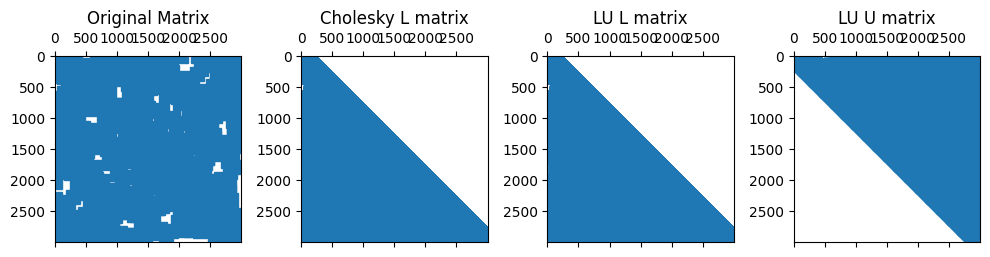

Cholesky time taken:  0.012529850006103516
LU time taken:  0.0408329963684082
Nonzero elements in original matrix:  9598
Nonzero elements in Cholesky L:  335682
Nonzero elements in LU L:  299576


In [4]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A, ordering_method="natural")
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
dt = time.time()

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(factor.L())
axes[1].set_title("Cholesky L matrix")
axes[2].spy(lu.L)
axes[2].set_title("LU L matrix")
axes[3].spy(lu.U)
axes[3].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/2419169893.py:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A)


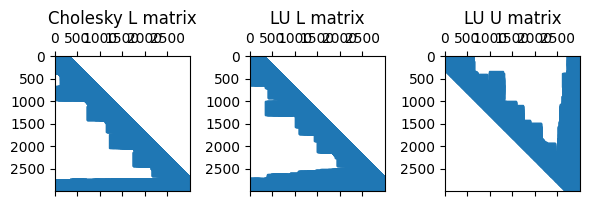

Cholesky time taken:  0.0017201900482177734
LU time taken:  0.004075050354003906
Nonzero elements in original matrix:  9598
Nonzero elements in Cholesky L:  18298
Nonzero elements in LU L:  34792


In [5]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A)
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc())
dt = time.time()

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(factor.L())
axes[0].set_title("Cholesky L matrix")
axes[1].spy(lu.L)
axes[1].set_title("LU L matrix")
axes[2].spy(lu.U)
axes[2].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

### Nested dissection algorythm

As LU and Cholesky algorythms derive factors in a pre-defined order, we can permute matrix in a way to make this algorythms produce minimal fill-in. One of approaches that works with SPD matrices is reducing to **block arrowhead structure**.

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} & 0 & A_{\alpha\sigma} \\ 0 & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

After decomposition, factors will have 0-blocks intact.

Main idea is that symmetric matrix $A$ can be seen as an adjacency matrix for some graph $G$. Then if we split $G$ into subgraphs $L, R, S$ in a way that there are no edges between nodes from $L$ and $R$, we can construct blocks, where node index is equal to matrix row/column index, and thus blocks $A_{LR}$ and $A_{RL}$ will be $0$.

The challenge in this approach is locating an optimal subset $S$ called **Separator** of nodes of $G$. **Separator** is a subgraph such that its removal splits the rest of the graph into two or more connected components.

Here we will choose separator using Spectral Partitioning approach (you can read about it in Lecture 11. Here is [a link](https://nla.skoltech.ru/lectures/lecture-11/lecture-11.html) to previous year's lecture if you want to see it sooner).

General algorythm is such:
1) Considering graph G based on given matrix A as an adjacency matrix for this graph, get the [Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) of that graph. 

2) Derive the eigenvector $w_2$ of graph's Laplacian that is corresponding to the second smallest eigenvalue.

3) Signs of components of $w_2$ define partitioning. Positive indexes define one class and negative - second class. These two classes are two connected components that will be left if we remove the separator class.

4) Derive indexes of Separator nodes - now we get indexes of all three classes $A, B, S$.

5) Permute matrix so rows and columns are ordered as $A, B, S$.

6) Iterate the same algorythm for blocks $A$ and $B$.

### Task 1 (5 pts): implement matrix separation

Implement given algorythm to permute matrix into lower-arrowhead block form (No recursion yet, we need only one split).

In [6]:
matrix = np.array([[4, 0, 0, 12],
                   [15, 0, 26, 34],
                   [0, -7, 15, 0]])

Below is my own implementation:

In [ ]:
def order_block_dissection(A):
    # Laplacian matrix
    degrees = np.array(A.sum(axis=1)).flatten()
    L = sp.diags(degrees, format='csr') - A

    # Second smallest eigenvector
    eigenvalues, eigenvectors = spsplin.eigsh(L, k=2, which='SM')
    fiedler_vector = eigenvectors[:, 1]

    # Partition nodes
    epsilon = 0
    pos_indices = np.where(fiedler_vector > epsilon)[0]
    neg_indices = np.where(fiedler_vector < -epsilon)[0]
    zero_indices = np.where(np.abs(fiedler_vector) <= epsilon)[0]
    A_nodes = np.concatenate((pos_indices, zero_indices))
    B_nodes = neg_indices

    # Identify separator
    partition_labels = np.zeros(A.shape[0], dtype=int)
    partition_labels[A_nodes] = 1
    partition_labels[B_nodes] = 2

    # Find all edges in the upper triangle to avoid duplicates
    row, col = A.nonzero()
    upper_mask = row < col
    row = row[upper_mask]
    col = col[upper_mask]

    # Identify edges that cross partitions (A to B)
    cross_partition = (partition_labels[row] == 1) & (partition_labels[col] == 2) | \
                      (partition_labels[row] == 2) & (partition_labels[col] == 1)
    S_nodes = np.unique(np.concatenate((row[cross_partition], col[cross_partition])))

    # Separator nodes
    S_nodes = S_nodes.tolist()

    # Remove separator nodes from A_nodes and B_nodes
    A_nodes = np.setdiff1d(A_nodes, S_nodes)
    B_nodes = np.setdiff1d(B_nodes, S_nodes)

    return A_nodes, B_nodes, S_nodes


def block_dissection(A, order):
    # return A_permuted
    return A[order, :][:, order]



In [19]:
n = 3000
k = 3
ex = np.ones(n)
A = sp.spdiags(np.vstack((2*ex,  8*ex, 2*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A + S.transpose() + S

In [20]:
L_node, R_node, S_node = order_block_dissection(A)
B = block_dissection(A, np.concatenate((L_node, R_node, S_node)).tolist())

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/2852956122.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(B, ordering_method="natural")


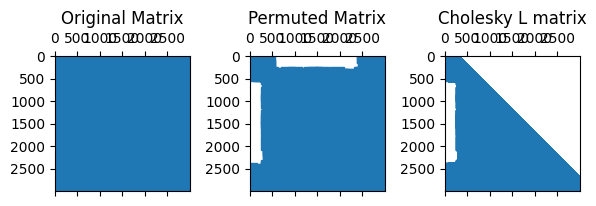

<Figure size 640x480 with 0 Axes>

Cholesky time taken:  0.013649225234985352
Nonzero elements in original matrix:  10996
Nonzero elements in Cholesky L:  654411


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

at = time.time()
factor = cholesky(B, ordering_method="natural")
bt = time.time()

axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(B)
axes[1].set_title("Permuted Matrix")
axes[2].spy(factor.L())
axes[2].set_title("Cholesky L matrix")
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print('==================================================')
print('Cholesky time taken: ', bt-at)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)

Below is solution generated with ChatGPT. That a pity, but it works better and faster :( 

In [12]:
def compute_laplacian(A):
    """
    Compute the Laplacian matrix of a graph given its adjacency matrix A.
    """
    degrees = np.array(A.sum(axis=1)).flatten()
    D = sp.diags(degrees, format='csr')
    L = D - A
    return L

def compute_fiedler_vector(L):
    """
    Compute the Fiedler vector (eigenvector corresponding to the second smallest eigenvalue).
    """
    # Since L is symmetric and positive semi-definite, we can use eigsh
    eigenvalues, eigenvectors = spsplin.eigsh(L, k=2, which='SM')
    idx = np.argsort(eigenvalues)
    fiedler_vector = eigenvectors[:, idx[1]]  # Second smallest eigenvalue
    return fiedler_vector

def partition_nodes(fiedler_vector, epsilon=1e-5):
    """
    Partition nodes into two classes based on the signs of the Fiedler vector components.
    """
    A_nodes = []
    B_nodes = []
    for i, val in enumerate(fiedler_vector):
        if val > epsilon:
            A_nodes.append(i)
        elif val < -epsilon:
            B_nodes.append(i)
        else:
            # Assign nodes with values close to zero arbitrarily
            A_nodes.append(i)
    return A_nodes, B_nodes

def find_separator_nodes(A, A_nodes, B_nodes):
    """
    Identify separator nodes that connect nodes from A_nodes to B_nodes.
    """
    S_nodes = set()
    A_set = set(A_nodes)
    B_set = set(B_nodes)
    # Check for connections between A_nodes and B_nodes
    for i in A_nodes:
        neighbors = A.indices[A.indptr[i]:A.indptr[i+1]]
        if any(j in B_set for j in neighbors):
            S_nodes.add(i)
    for i in B_nodes:
        neighbors = A.indices[A.indptr[i]:A.indptr[i+1]]
        if any(j in A_set for j in neighbors):
            S_nodes.add(i)
    # Remove separator nodes from A_nodes and B_nodes
    A_nodes = [i for i in A_nodes if i not in S_nodes]
    B_nodes = [i for i in B_nodes if i not in S_nodes]
    S_nodes = list(S_nodes)
    return A_nodes, B_nodes, S_nodes

def create_permutation_order(A_nodes, B_nodes, S_nodes):
    """
    Create a permutation order for the matrix based on the node partitions.
    """
    permutation = A_nodes + B_nodes + S_nodes
    return permutation

def permute_matrix(A, permutation):
    """
    Permute the matrix A according to the given permutation of indices.
    """
    # Permute the rows and columns of the sparse matrix
    A_permuted = A[permutation, :][:, permutation]
    return A_permuted

def permute_to_arrowhead(A):
    """
    Main function to permute the matrix A into lower-arrowhead block form.
    """
    # Step 1: Compute the Laplacian of the graph
    L = compute_laplacian(A)
    # Step 2: Compute the Fiedler vector
    w2 = compute_fiedler_vector(L)
    # Step 3: Partition nodes based on the Fiedler vector
    A_nodes, B_nodes = partition_nodes(w2)
    # Step 4: Identify separator nodes
    A_nodes, B_nodes, S_nodes = find_separator_nodes(A, A_nodes, B_nodes)
    # Step 5: Create permutation order
    permutation = create_permutation_order(A_nodes, B_nodes, S_nodes)
    # Step 6: Permute the matrix
    A_permuted = permute_matrix(A, permutation)
    return A_permuted, permutation


In [13]:
C, _ = permute_to_arrowhead(A)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/2900424114.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(C, ordering_method="natural")


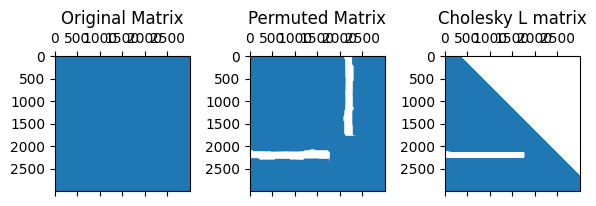

<Figure size 640x480 with 0 Axes>

Cholesky time taken:  0.013360261917114258
Nonzero elements in original matrix:  10998
Nonzero elements in Cholesky L:  581366


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

at = time.time()
factor = cholesky(C, ordering_method="natural")
bt = time.time()

axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(C)
axes[1].set_title("Permuted Matrix")
axes[2].spy(factor.L())
axes[2].set_title("Cholesky L matrix")
plt.tight_layout()
plt.show()



plt.tight_layout()
plt.show()

print('==================================================')
print('Cholesky time taken: ', bt-at)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)

### Task 2 (5 pts): implement Nested Dissection



Now implement algorithm that will recursively permute each of $A_{iLL}$ and $A_{iRR}$ blocks to their own lower-arrowhead bock form.

Reminder: you are permuting the whole matrix, not each block separately.

Reminder: it is a good idea to move all $A_{iSS}$ blocks together on the bottom.

In [22]:
# A - PSD matrix
# k - maximal block size

def nested_dissection(A, k=10):
    
    def recursive_nd(A, nodes, k):
       
        if len(nodes) <= k:
            return nodes.copy()
        
        # Extract the submatrix corresponding to current nodes
        subA = A[nodes, :][:, nodes]
        
        # Partition the submatrix into A, B, S using permute_to_arrowhead
        A_nodes, B_nodes, S_nodes = order_block_dissection(subA)
        
        # Map back to original node indices
        A_nodes_original = [nodes[i] for i in A_nodes]
        B_nodes_original = [nodes[i] for i in B_nodes]
        S_nodes_original = [nodes[i] for i in S_nodes]
        
        # Recursively apply Nested Dissection on A and B
        perm_A = recursive_nd(A, A_nodes_original, k)
        perm_B = recursive_nd(A, B_nodes_original, k)
        
        # Combine the permutation orders: A, B, S
        return perm_A + perm_B + S_nodes_original
    
    # Start recursion with all nodes
    all_nodes = list(range(A.shape[0]))
    permutation = recursive_nd(A, all_nodes, k)
    
    return permutation

In [23]:
n = 3000
k = 5
ex = np.ones(n)
A = sp.spdiags(np.vstack((1*ex,  3*ex, 1*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A+ S.transpose() + S

In [35]:
# order = lr + s
permutation_order = nested_dissection(A, 20)
B = block_dissection(A, permutation_order)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/673294425.py:6: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorA = cholesky(A, ordering_method="natural")
/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/673294425.py:9: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorB = cholesky(B, ordering_method="natural")
/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/673294425.py:12: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorC = cholesky(A)


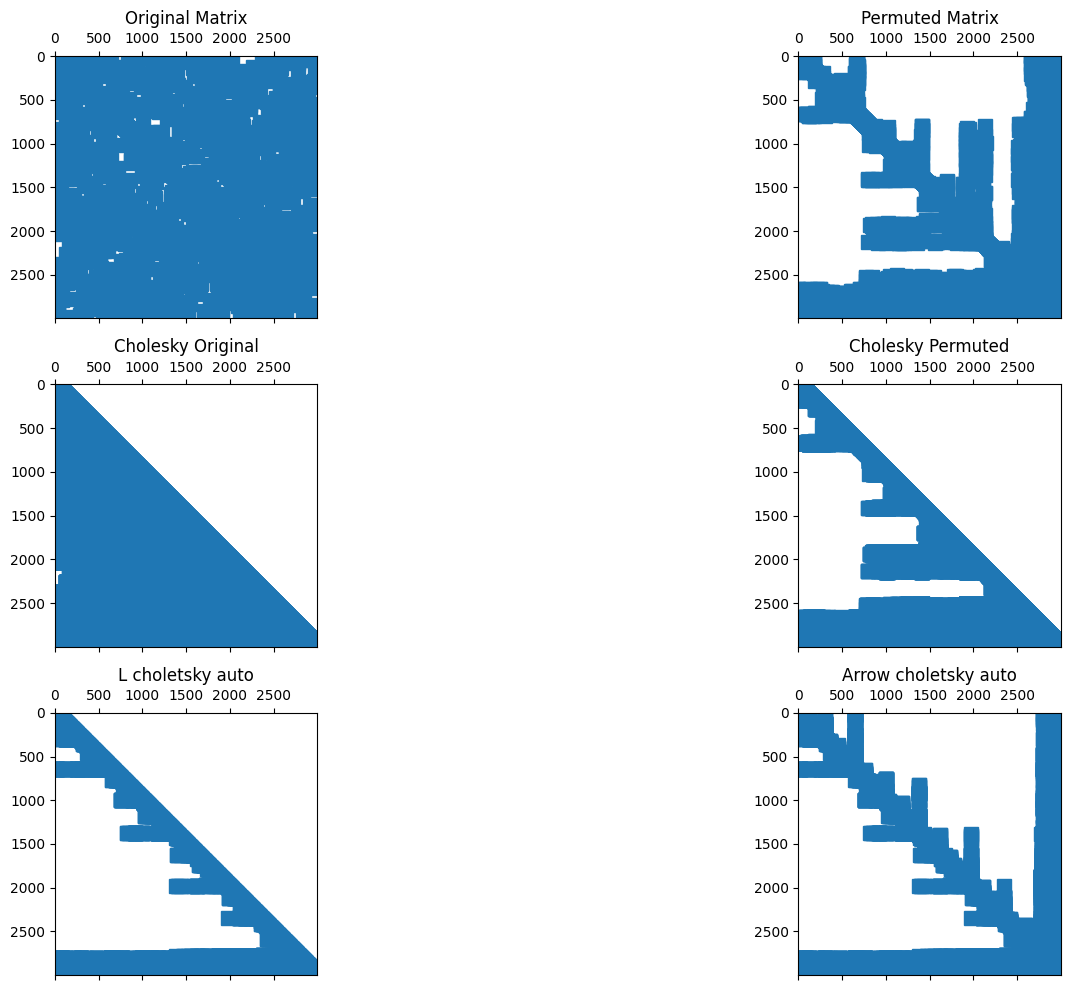

Nonzero elements in original matrix:     10198
Nonzero elements in Cholesky L:          600263
Nonzero elements in permuted Cholesky L: 155900
78082


In [39]:
fig, axes = plt.subplots(3, 2, figsize=(19, 10))
axes[0,0].spy(A)
axes[0,0].set_title("Original Matrix")
axes[0,1].spy(B)
axes[0,1].set_title("Permuted Matrix")
factorA = cholesky(A, ordering_method="natural")
axes[1,0].spy(factorA.L())
axes[1,0].set_title("Cholesky Original")
factorB = cholesky(B, ordering_method="natural")
axes[1,1].spy(factorB.L())
axes[1,1].set_title("Cholesky Permuted")
factorC = cholesky(A)
axes[2,0].spy(factorC.L())
axes[2,0].set_title("L choletsky auto")
arrow = factorC.L() @ factorC.L().T
axes[2,1].spy(arrow)
axes[2,1].set_title("Arrow choletsky auto")
plt.tight_layout()
plt.show()

print('Nonzero elements in original matrix:    ', A.nnz)
print('Nonzero elements in Cholesky L:         ', factorA.L().nnz)
print('Nonzero elements in permuted Cholesky L:', factorB.L().nnz)
print(factorC.L().nnz)

### Demonstration: Animation of heat distribution in a wall

Consider simulating heat distribution in a large mechanical component (e.g., a car engine block or a building wall). The thermal conduction equation is modeled using the **Heat Equation**, a PDE:

$$
\frac{\partial T}{\partial t} = \nabla \cdot (k \nabla T) + Q,
$$
where:
- $ T $: temperature,
- $ k $: thermal conductivity,
- $ Q $: heat source.

Using [Finite Element Method](https://clck.ru/3EvWw3) we represent continuous solid object as a set of small separate objects. Each of them transfers heat only to neighbouring pieces. Thus, if we represent temperature of all $n$ pieces in a vector $T$ we can construct $n \times n$ adjacency matrix $A$, in which each non-zero element $a_{i,j}$ represents heat conductivity between elements $i$ and $j$, and the initial equation [can be represented](https://skim.math.msstate.edu/LectureNotes/NumerPDEs_Lecture.pdf) as:
$$
AT_{t+1}=T_t
$$

To make calculations more accurate, we need to represent object with larger number $n$ of small pieces of size $1/k$. However, size of $A$ is $\mathcal{O}(k^4)$ for a 2D object and $\mathcal{O}(k^9)$ for 3D object, which may be way too large.

However, $A$ has an important feature - it is sparse, positive and symmetric. This will allow us to use sparse methods and fast Cholesky factorization for quick solution. Also, computationally-expensive computation of matrix permutation can be done only once, as adjacency matrix does not change.



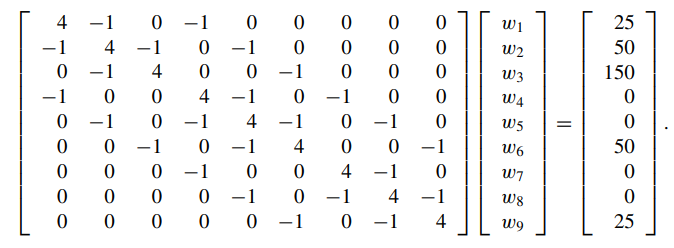

In [40]:
def adjacency_conductivity_matrix(Nx, Ny, alpha):
    N = Nx * Ny  # Total number of nodes
    A = sp.lil_matrix((N, N))  # Initialize sparse adjacency matrix

    for i in range(Nx):
        for j in range(Ny):
            node = i * Ny + j
            if i > 0:  # Above
                neighbor = (i - 1) * Ny + j
                A[node, neighbor] = 1
            if i < Nx - 1:  # Below
                neighbor = (i + 1) * Ny + j
                A[node, neighbor] = 1
            if j > 0:  # Left
                neighbor = i * Ny + (j - 1)
                A[node, neighbor] = 1
            if j < Ny - 1:  # Right
                neighbor = i * Ny + (j + 1)
                A[node, neighbor] = 1

    I = sp.eye(Nx*Ny, format="csr")
    return (1+4*alpha)*I - alpha*A

In [44]:
def predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames):
  order = nested_dissection(A, 500)
  B = A[order, :][:, order]

  cholesky_factorization = cholesky(B, ordering_method='natural')

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T[order])[np.argsort(order)]
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [42]:
Nx, Ny = 3, 3                                    # Number of grid points in x and y
alpha = 0.1
T = np.array([25, 50, 150, 0, 0, 50, 0, 0, 25])  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)
A.toarray()

array([[ 1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.1,  1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  1.4,  0. ,  0. , -0.1,  0. ,  0. ,  0. ],
       [-0.1,  0. ,  0. ,  1.4, -0.1,  0. , -0.1,  0. ,  0. ],
       [ 0. , -0.1,  0. , -0.1,  1.4, -0.1,  0. , -0.1,  0. ],
       [ 0. ,  0. , -0.1,  0. , -0.1,  1.4,  0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. , -0.1,  0. ,  0. ,  1.4, -0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4, -0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4]])

In [45]:
n_frames = 10
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

/var/folders/7k/4vb9j3_s13l8qv3m4vdw9m5w0000gn/T/ipykernel_22949/963583958.py:5: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 7157.52it/s]


In [46]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500, blit=True)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [47]:
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)

In [48]:
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

### Task 3 (5 pts):
Compare computation and memory efficiency of Cholesky using intact matrix with your implementation of Nested Dissection with built-in method.

In [ ]:
def predict_heat_distribution_naive(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T, ordering_method='natural')
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [ ]:
def predict_heat_distribution(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
  return frames

## Clusterisation of musical notes with FFT and PCA (10 pts)

A [link](https://drive.google.com/drive/folders/11Nvytewu8_QAWOTPGkfDD0bl9j5lb8Ee?usp=sharing) to the wav files.

In [ ]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

### Implement FFT via Cooley-Tukey (check lectures) (5 pts)

In [ ]:
def FFT(x):
    """
    1D Cooly-Tukey, for input of size 2**n
    """


    '''
    Replace with your own implementation
    '''

    return fft(x)

### PCA (use SVD library func) (5 pts)

In [ ]:
def calc_PCA(matrix, n_components):
    # as input: matrix (n_samples, n_features)
    # as output: matrix (n_samples, n_features)

    '''
    replace with your own func!
    '''

    from sklearn.decomposition import PCA
    a = PCA(n_components)
    return a.fit_transform(matrix)

### Read files + Utils

In [ ]:
def process_audio(filename):
    samplerate, data = wavfile.read(f'./{filename}.wav')
    if len(data.shape) > 1:
        # convert to mono
        data = data[:, 0]

    data_splitted = []

    w_size = 2048
    for indent in [0, 512, 1024, 1024 + 512]:
        data_i = data[indent:]
        data_i = data_i[:data_i.shape[0] - data_i.shape[0] % w_size]
        n_splits = data_i.shape[0] // w_size
        # print(data.shape)
        data_splitted.append(np.split(data_i, n_splits))

    data_splitted = np.concatenate(data_splitted)


    a = FFT(data_splitted)
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)
    return a, [filename] * a.shape[0]

In [ ]:
chunks, labels = [], []

for fl in ['a1', 'b1', 'c1', 'e1', 'f1', 'g1', 'a1s', 'c1s', 'd1s', 'f1s', 'g1s']:
    z, x = process_audio(fl)
    chunks.append(z)
    labels.append(x)



In [ ]:
labels_concat = []
for l in labels:
    labels_concat += l

In [ ]:
chunks_np = np.abs(np.concatenate(chunks))

In [ ]:
chunks_fitted = calc_PCA(chunks_np, 4)

### Visualisation

In [ ]:
colors = {
    'a1': 'red',
    'a1s': 'pink',
    'b1': 'green',
    'c1': 'blue',
    'c1s': 'olive',
    'd1s': 'purple',
    'e1': 'cyan',
    'f1': 'orange',
    'f1s': 'black',
    'g1': 'yellow',
    'g1s': 'blueviolet',

}
color_labels = [colors[d] for d in labels_concat]

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 3], color=color_labels)

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 2], color=color_labels)